### How well do jobs & skills pay for Data Analysts?

Methodology:

1. Evaluate median salary for top 6 data jobs
2. Find median salary per skill for Data Analysts
3. Visualize for highest paying skills and most demanded skills


In [1]:
from datasets import load_dataset
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading data
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset["train"].to_pandas()

In [3]:
# Clean up data
df["job_posted_date"] = pd.to_datetime(df["job_posted_date"])
df["job_skills"] = df["job_skills"].apply(
    lambda job_skill: ast.literal_eval(job_skill) if pd.notna(job_skill) else job_skill
)

In [4]:
# Filter for jobs in the US
df_US = df.loc[df["job_country"] == "United States"].dropna(subset="salary_year_avg")

In [5]:
# Only get the top 6 jobs
top_jobs = df_US["job_title_short"].value_counts().index[:6]
df_US_top = df_US.loc[df["job_title_short"].isin(top_jobs)]
job_order = (
    df_US_top.groupby("job_title_short")["salary_year_avg"]
    .median()
    .sort_values(ascending=False)
    .index
)

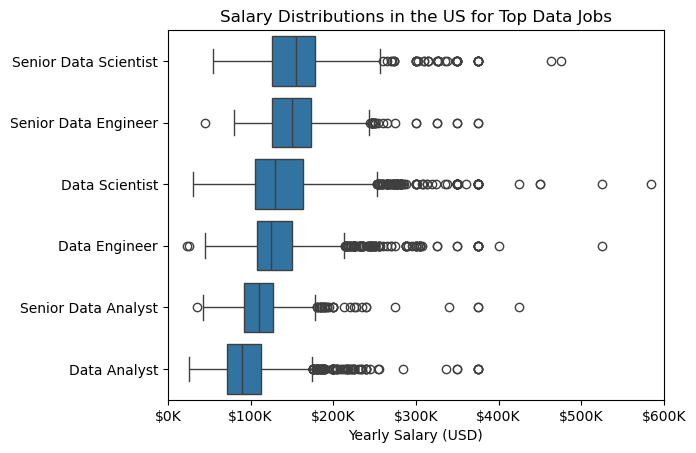

In [6]:
sns.boxplot(data=df_US_top, x="salary_year_avg", y="job_title_short", order=job_order)
plt.xlabel("Yearly Salary (USD)")
plt.ylabel(None)
plt.title("Salary Distributions in the US for Top Data Jobs")
plt.xlim(0, 600000)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x/1000:.0f}K"))

In [7]:
# Filter only data analyst jobs in the US
df_DA_US = df.loc[
    (df["job_title_short"] == "Data Analyst") & (df["job_country"] == "United States")
].copy()
df_DA_US.dropna(subset="salary_year_avg", inplace=True)
df_DA_US_explode = df_DA_US.explode("job_skills")

In [8]:
# Group by job_skills for plotting top paid skills & most in-demand skills
df_DA_US_skills = df_DA_US_explode.groupby("job_skills")["salary_year_avg"].agg(
    ["count", "median"]
)
df_DA_US_skills

,count,median
job_skills,,
airflow,44,116250.00
airtable,5,90000.00
alteryx,106,106281.25
angular,8,107500.00
ansible,1,159640.00
...,...,...
wire,4,74250.00
word,461,81194.75
workfront,3,75000.00


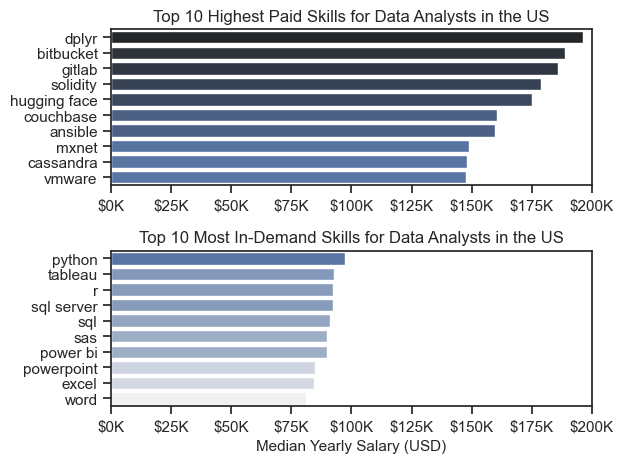

In [10]:
# Plot for top 10 skills with highest paid (median) vs most in-demand (count)
sort_values = {"median": "Highest Paid", "count": "Most In-Demand"}
color = ["dark:b_r", "light:b"]
fig, ax = plt.subplots(len(sort_values), 1)
sns.set_theme(style="ticks")
for i, (sort_value, title) in enumerate(sort_values.items()):
    df_DA_US_plot = (
        df_DA_US_skills.sort_values(sort_value, ascending=False)
        .head(10)
        .sort_values("median", ascending=False)
    )
    sns.barplot(
        df_DA_US_plot,
        x="median",
        y="job_skills",
        ax=ax[i],
        hue="median",
        palette=color[i],
        legend=None,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(f"Top 10 {title} Skills for Data Analysts in the US")
    ax[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x/1000:,.0f}K"))
    ax[i].set_xlim(0, round(max(df_DA_US_skills["median"]), -4))
    if i != len(sort_values) - 1:
        ax[i].set_xlabel(None)
    else:
        ax[i].set_xlabel("Median Yearly Salary (USD)", fontsize=11)
fig.tight_layout()